In [1]:
%matplotlib inline

import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf

if "../" not in sys.path:
    sys.path.append("../")

from libr import plotting    
from collections import deque, namedtuple
from matplotlib import pyplot as plt

In [2]:
env = gym.envs.make("Breakout-v0")

4


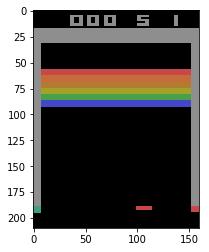

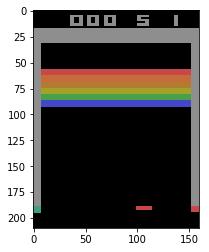

In [3]:
print(env.action_space.n)
plt.figure()
observation = env.reset()
plt.imshow(env.render(mode='rgb_array'))
[env.step(2) for x in range(1)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

(210, 160, 3)


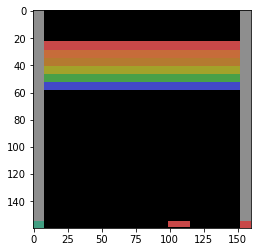

In [4]:
print(observation.shape)
plt.imshow(observation[34:-16,:,:])

In [5]:
# 4 valid actions are available
valid_actions = [0,1,2,3]

In [6]:
class StateProcessor():
    """
    Resize and grascale image. 
    """
    def __init__(self):
        # Build the tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84,84], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
            )
            self.output = tf.squeeze(self.output)
            
    def process(self, sess, state):
        """
        Args: 
            sess: A tensorflow session object
            state: A [210, 160, 3] Atari RGB State
            
        Returns: 
            A processed [84,84,1] state representing grayscale values
        """
        
        return sess.run(self.output, {self.input_state: state})

In [7]:
class Estimator():
    """
    Q-Value Estimator neural network. 
    
    This network is used for both the Q-Network and the target network.
    """
    
    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # writes tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            #build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summaries_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
            
            
    def _build_model(self):
        """
        Build the tensorflow graph.
        """
        
        # Placeholers for our input
        # Our input are 4 RGB frames of shape 160(84*), 160(84*) each 
        
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype = tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype= tf.int32, name="actions")
        
        X = tf.to_float(self.X_pl)/255.0
        batch_size = tf.shape(self.X_pl)[0]
        
        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
                X, 32, 8, 4, activation_fn = tf.nn.relu
                )
        
        conv2 = tf.contrib.layers.conv2d(
                conv1, 64, 4, 2, activation_fn = tf.nn.relu
        )
        
        conv3 = tf.contrib.layers.conv2d(
                conv2, 64, 3, 1, activation_fn = tf.nn.relu
        )
        
        # fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(valid_actions))
        
        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)
        
        # calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)
    
        # optimizer parameters from the original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())
        
        # summaries for tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])
        
    
    def predict(self, sess, s):
        """
        Predict action values.
        Args: 
            sess: Tensorflow session
            s: State input of shape [batch_size, 4, 160, 160, 3]
            
        Returns: 
            Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated
            action values.
        """
        return sess.run(self.predictions, {self.X_pl: s})
        
    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.
        
        Args: 
            sess: Tensorflow session object
            s: state input of shape [batch_size, 4, 160, 160, 3]
            a: chosen actions of shape [batch_size]
            y: Targets of shape[batch_size]
            
        Returns:
            The calculated loss on the batch. 
        """
        
        feed_dict = {self.X_pl: s, self.y_pl:y, self.actions_pl:a}
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
            
        return loss

In [8]:
tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    observation = env.reset()
    
    observation_p = sp.process(sess, observation)
    observation = np.stack([observation_p] * 4, axis =2)
    observations = np.array([observation] * 2)
    
    # test prediction
    print(e.predict(sess, observations))
    
    # test training step
    y = np.array([10.0, 10.0])
    a = np.array([1,3])
    print(e.update(sess, observations, a, y))

/Users/vihangpatil/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[[ 0.00137653  0.          0.08495298  0.        ]
 [ 0.00137653  0.          0.08495298  0.        ]]
100.0


In [9]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph. 
        Args: 
            estimator1: Estimator to copy the parameters from
            estimator2: Estimator to copy the parameters to
        """
        
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v:v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v:v.name)
        
        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy. 
        Args:
            sess: Tensorflow session instance
        """
        
        sess.run(self.update_ops)

In [10]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon greedy policy based on a given Q function approximator and epsilon.
    
    Args: 
        Estimator: an estimator that returns q values for a give state.
        nA: Number of actions in the environment.
        
    Reutrns: 
        A function that takes the (sess, observation, epsilon) as an argument and 
        returns the propbabilites for each action in the form of numpy array of length aA.
    """
    
    def policy_fn(sess, observation, epsilon):
        
        A = np.ones(nA, dtype = float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [18]:
def deep_q_learning(sess,
                    env,
                    q_esimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size = 10000,
                    replay_memory_init_size = 5000,
                    update_target_estimator_every = 10000,
                    discount_factor = 0.99,
                    epsilon_start = 1.0,
                    epsilon_end = 0.1,
                    epsilon_decay_steps = 500000,
                    batch_size = 32,
                    record_video_every = 50):
    
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation. 
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        sess: Tensorflow session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: estimator object used for the targets
        state_processor: A state processor object
        num_episodes: number of episodes to run for
        experiment_dir: directory to save tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sample when 
        initializing the replay memory
        discount_factor: gamma
        epsilon_start: chance to sample a random action when taking an action
        Epsilon is decayed over time and this is the start value. 
        epsilon_end: end value of epsilon
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: size of batches to sample from the replay memory
        record_video_every: record a video every N episodes
        
    Returns: 
        An episodestats object with two numpy arrays for episode_lengths and
        episode_rewards.
    """
    Transition = namedtuple("Transition",["state", "action", "next_state", "done"])
    
    # the replay memory
    replay_memory = []
    
    # make model copier object
    estimator_copy = ModelParametersCopier(q_esimator, target_estimator)
    
    # keeps target of useful statistics
    stats = plotting.EpisodeStats(
            episode_lengths = np.zeros(num_episodes),
            episode_rewards = np.zeros(num_episodes)
            )
    
    # for 'system/' summaries, useful to check if current process looks healthy
    
    current_process = psutil.Process()
    
    # Create directories for checkpoints and summaries
    
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir,"monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)
        
    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    
    if latest_checkpoint:
        print("loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
        
    # get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())
    
    # the epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
    
    # the policy we are follwing
    policy = make_epsilon_greedy_policy(
            q_esimator,
        len(valid_actions)
    )
    
    # Populate the replay memory with initial experience
   print("Populating replay memory...")
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(valid_actions[action])
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state
            
    # Record videos
    # Add env monitor wrapper
            
    env = Monitor(env, directory=monitor_path, video_callable=lambda count: count % record_video_every==0, resume=True)
            
    for i_episode in range(num_episodes):
        
        # save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)
        
        # Reset the environment
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)
        loss = None
        
        for t in itertools.count():
            
            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]
            
            # Maybe update the target estimator
            if total_t % update_target_estimator_every ==0:
                estimator_copy.make(sess)
                print("\n copied model parameters to target network")
                
            # Print out which step we are on, useful for debugging
            print("\r step {} ({}) @ epsiode {}/{}, loss: {}".format(
            t, total_t, i_episode + 1, num_episodes, loss), end="")
            
            sys.stdout.flush()
            
            # take a step
            
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p =action_probs)
            next_state, reward, done, _= env.step(valid_actions[action])
            next_state = state_processor.process(sess,  next_state)
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state,2), axis=2)
            
            # if our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
                
            # save the transistion to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))
            
            # update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
            
            # calculate q values and targets
            
            q_values_next = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)
            
            # perform gradient descent update
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)
            
            if done:
                break
            
            state = next_state
            total_t += 1
            
        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=stats.episode_rewards[i_rewards],tag="episode/reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_rewards],tag="episode/length")
        episode_summary.value.add(simple_value = current_process.cpu_percent(), tag="system/cpu_usage_percent")
        episode_summary.value.add(simple_value = current_process.memory_percent(memtype="vms"), tag="system/v_memory_usage_percent")
        q_estimator.summary_writer.add_summary(episode_summary, i_episode)
        q_estimator.summary_writer.flush()

        yield total_t, plotting.EpisodeStats(
                episode_lengths = stats.episode_lengths[:i_episode+1],
                episode_rewards = stats.episode_rewards[:i_episode+1]
        )
        
    return stats

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 95)

In [19]:
tf.reset_default_graph()

# where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))

# Create a global step variable
global_step = tf.Variable(0, name='global_step', trainable=False)

# Create estimators
q_estimator = Estimator(scope = "q_estimator", summaries_dir=experiment_dir)
target_estimator = Estimator(scope = "target_q")

# state processor
state_processor = StateProcessor()

# Run

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(
        sess,
        env,
        q_esimator = q_estimator,
        target_estimator = target_estimator,
        state_processor = state_processor,
        experiment_dir = experiment_dir,
        num_episodes = 1000,
        replay_memory_size = 5000,
        replay_memory_init_size = 5000,
        update_target_estimator_every = 50,
        epsilon_start = 1.0,
        epsilon_end = 0.1,
        epsilon_decay_steps = 50000,
        discount_factor = 0.99,
        batch_size = 32
    ):
        print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))

/Users/vihangpatil/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


populating replay memory...


ValueError: all the input arrays must have same number of dimensions